<a href="https://www.kaggle.com/code/mennatullaheisawy/lung-and-colon-cancer-classification-using-cnn?scriptVersionId=188951854" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Overview
This notebook focuses on the classification of histopathological images from a dataset containing 25,000 images, organized into five distinct classes. Each image is 768 x 768 pixels and in JPEG format. The dataset originates from 750 lung tissue images and 500 colon tissue images, which were augmented to the current size using the Augmentor package.

### Dataset Details
The dataset comprises five classes with 5,000 images each:
- Lung benign tissue
- Lung adenocarcinoma
- Lung squamous cell carcinoma
- Colon benign tissue
- Colon adenocarcinoma

These images are derived from HIPAA-compliant and validated sources, including lung and colon tissues. The original dataset is detailed in the paper by Borkowski et al. (2019).

### Workflow
1. **Data Import and Preparation**:
   - Imported the dataset and read the images using a predefined function.
   - Employed an image data generator for data augmentation and preprocessing.

2. **Model Building and Fine-Tuning**:
   - Developed various model architectures to explore different hyperparameters.
   - Fine-tuned models based on training, validation, and test accuracies and losses.
   - Monitored accuracy and loss plots across epochs to assess overfitting or underfitting.

3. **Final Model**:
   - Achieved a test accuracy of 93% and a training accuracy of 98%.
   - Ensured the accuracy and loss plots across epochs were reasonable, indicating a well-generalized model.

### Results
The final model demonstrates high accuracy and effective generalization on the test set, making it a robust solution for histopathological image classification.

#### Call to Action
If you find this notebook helpful or have any suggestions, please feel free to upvote and share your thoughts. Your feedback is highly appreciated and will help in improving this work. Thank you! 👍🙌




					Best Model Plots




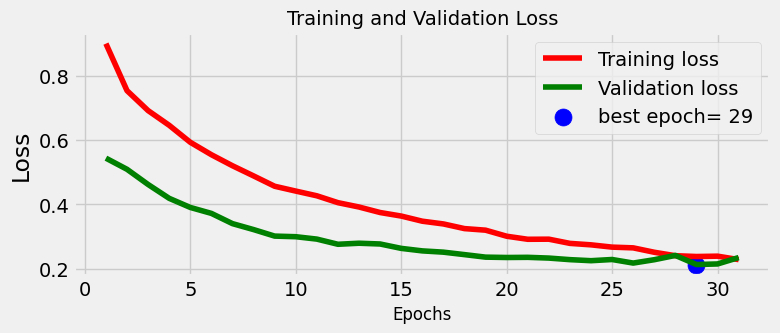

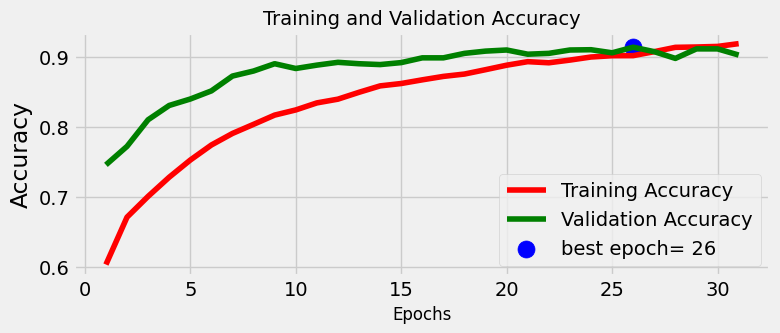



					Models Summary




,Model_Name,tr_loss,val_loss,test_loss,tr_acc,val_acc,test_acc,no_of_conv_layers,max_no_of_filters,no_of_dense_layers(hidden),no_of_neurons_at_first_hidden,padding,drop_out,learning_rate,epochs
0,model_1,0.261125,0.345305,0.315903,0.89225,0.8492,0.8668,2,32,2,32,valid,0.4,0.00100,30
1,model_2,0.019798,0.217905,0.183728,0.99530,0.9260,0.9340,2,64,2,64,valid,0.2,0.00010,30
2,model_3,0.444055,0.506139,0.465240,0.85505,0.8244,0.8492,2,64,2,64,same,0.4,0.00010,50
3,model_4,0.152503,0.277470,0.255336,0.95780,0.8924,0.9044,2,64,2,64,same,0.4,0.00001,50
4,model_5,0.073319,0.217022,0.174034,0.98300,0.9140,0.9380,2,64,2,128,valid,0.4,0.00001,50


In [54]:
# DO NOT RUN THIS CELL 
# --> This is just for showing the final results
print("\n\n\t\t\t\t\tBest Model Plots\n\n")
plot_loss_accuracy(history5)
print('\n\n\t\t\t\t\tModels Summary\n\n')
models_details


## Import Libraries

In [1]:
import os
import cv2
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2024-07-19 05:24:30.659127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 05:24:30.659237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 05:24:30.798252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Read the Data to a dataframe

    - Using Pre-defined Function

In [2]:
def read_data_from_directory(path):
    filepaths, labels = [],[]
    folders = os.listdir(path)
    for folder in folders:
        folderpath= os.path.join(path, folder)
        classes = os.listdir(folderpath)
        for clas in classes:
            claspath= os.path.join(folderpath, clas)
            files = os.listdir(claspath)
            for file in files:
                filepath= os.path.join(claspath, file)
                filepaths.append(filepath)
                labels.append(clas)
    data_df = pd.DataFrame(data={'file_paths':filepaths, 'labels':labels})
    return data_df

In [3]:
data_df = read_data_from_directory('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set')
data_df['labels'].value_counts()

labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64

## Train_Val_Test Split

In [4]:
train_df, dummy = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df['labels'])
val_df, test_df = train_test_split(dummy, test_size=0.5, random_state=42, stratify=dummy['labels'])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(20000, 2)
(2500, 2)
(2500, 2)


## Image Data Generation

In [5]:
gen= ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels',
                                   target_size=(224,224), color_mode='rgb', class_mode='categorical',
                                   batch_size=16, shuffle=True)
valid_gen = gen.flow_from_dataframe(val_df, x_col='file_paths', y_col='labels',
                                   target_size=(224,224), color_mode='rgb', class_mode='categorical',
                                   batch_size=8, shuffle=True)
test_gen = gen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels',
                                   target_size=(224,224), color_mode='rgb', class_mode='categorical',
                                   batch_size=8, shuffle=False)


Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


### Models Archeticture

#### Model 1

In [11]:
lr=0.001
drop = 0.4
f1 = 32
f2 = 16
d1 = 32
d2 = 16
p ='valid'

model1 = Sequential([
    Conv2D(f1, kernel_size=(5,5), input_shape=(224,224,3), activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Conv2D(f2, kernel_size=(3,3),activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(d1,activation='relu'),
    Dropout(drop),
    
    Dense(d2,activation='relu' ),
    Dense(5, activation='softmax')
    
])

model1.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 108, 108, 16)   │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46656)          │       186,624 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │     1,493,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,687,317 (6.44 MB)

 Trainable params: 1,594,005 (6.08 MB)

 Non-trainable params: 93,312 (364.50 KB)

In [12]:
ep = 30
call_back1 = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5, verbose=0)
history1 = model1.fit(train_gen, epochs=ep, callbacks=call_back1, validation_data=valid_gen, verbose=1)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 91ms/step - accuracy: 0.5816 - loss: 1.3157 - val_accuracy: 0.5656 - val_loss: 1.8373
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.6880 - loss: 0.6829 - val_accuracy: 0.7340 - val_loss: 0.6031
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 105s 84ms/step - accuracy: 0.7254 - loss: 0.6048 - val_accuracy: 0.6132 - val_loss: 0.9582
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 105s 84ms/step - accuracy: 0.7695 - loss: 0.5319 - val_accuracy: 0.5924 - val_loss: 1.2898
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - accuracy: 0.7999 - loss: 0.4867 - val_accuracy: 0.8492 - val_loss: 0.3453
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 109s 87ms/step - accuracy: 0.8240 - loss: 0.4333 - val_accuracy: 0.6640 - val_loss: 0.9471
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - accuracy: 0.8437 - loss: 0.3915 - val_accuracy: 0.5368 - val_loss: 4.6657
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 86ms/step - accuracy: 

#### Plotting Model Losses and Accuracies
    
    - Using predefined functions

In [6]:
def plot_loss(history):
    # Define needed variables
    tr_loss = history.history['loss']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_loss))]
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize= (8, 3))
    plt.style.use('fivethirtyeight')

    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()


def plot_accuracy(history):
    # Define needed variables
    tr_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    index_acc = np.argmax(val_accuracy)
    val_highest = val_accuracy[index_acc]

    Epochs = [i+1 for i in range(len(tr_accuracy))]
    accuracy_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (8, 3))
    plt.style.use('fivethirtyeight')

    plt.plot(Epochs, tr_accuracy, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_accuracy, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1, val_highest, s= 150, c= 'blue', label= accuracy_label)
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

def plot_loss_accuracy(history):
    plot_loss(history)    
    plot_accuracy(history)


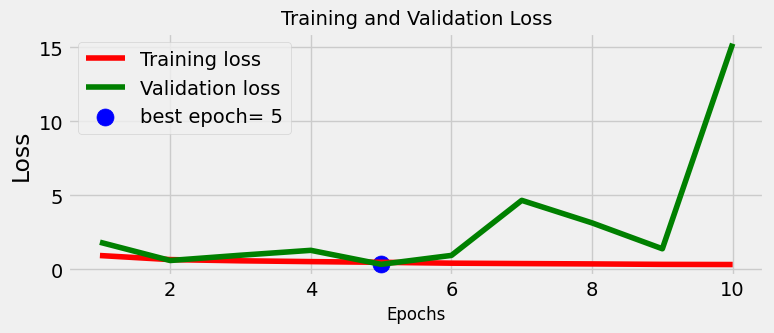

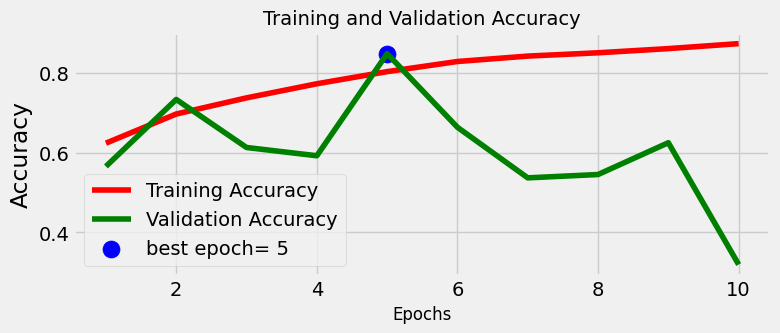

In [13]:
plot_loss_accuracy(history1)

### Model Testing and Evaluation

In [14]:
tr_eval = model1.evaluate(train_gen) 
tr_loss = tr_eval[0]
tr_acc = tr_eval[1]

val_eval = model1.evaluate(valid_gen) 
val_loss = val_eval[0]
val_acc = val_eval[1]

test_eval = model1.evaluate(test_gen) 
test_loss = test_eval[0]
test_acc = test_eval[1]

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - accuracy: 0.8919 - loss: 0.2602
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8569 - loss: 0.3352
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8559 - loss: 0.3293


In [15]:
# Define new dataframe that includes all the hyperparemetrs details, losses, and accuracies for each model
models_details = pd.DataFrame(data={'Model_Name':['model_1'],
                                    'tr_loss':[tr_loss], 
                                    'val_loss':[val_loss], 
                                    'test_loss':[test_loss],
                                    'tr_acc':[tr_acc],
                                    'val_acc':[val_acc],
                                    'test_acc':[test_acc],
                                    'no_of_conv_layers':[2], 
                                    'max_no_of_filters':[max(f1,f2)],
                                    'no_of_dense_layers(hidden)':[2], 
                                    'no_of_neurons_at_first_hidden':[d1], 
                                    'padding':[p],
                                    'drop_out':[drop],
                                    'learning_rate':[lr], 
                                    'epochs':[ep], 
                                    })

models_details


,Model_Name,tr_loss,val_loss,test_loss,tr_acc,val_acc,test_acc,no_of_conv_layers,max_no_of_filters,no_of_dense_layers(hidden),no_of_neurons_at_first_hidden,padding,drop_out,learning_rate,epochs
0,model_1,0.261125,0.345305,0.315903,0.89225,0.8492,0.8668,2,32,2,32,valid,0.4,0.001,30


#### Model 2

In [16]:
lr=0.0001
drop = 0.2
f1 = 64
f2 = 32
d1 = 64
d2 = 32
p ='valid'

model2 = Sequential([
    Conv2D(f1, kernel_size=(5,5), input_shape=(224,224,3), activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Conv2D(f2, kernel_size=(3,3),activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(d1,activation='relu'),
    Dropout(drop),
    
    Dense(d2,activation='relu' ),
    Dense(5, activation='softmax')
    
])

model2.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 108, 108, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 93312)          │       373,248 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,370,853 (24.30 MB)

 Trainable params: 6,184,229 (23.59 MB)

 Non-trainable params: 186,624 (729.00 KB)

In [17]:
ep = 30
call_back2 = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5, verbose=0)
history2 = model2.fit(train_gen, epochs=ep, callbacks=call_back2, validation_data=valid_gen, verbose=1)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 119s 90ms/step - accuracy: 0.7076 - loss: 0.6758 - val_accuracy: 0.7576 - val_loss: 0.5090
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.8630 - loss: 0.3363 - val_accuracy: 0.8576 - val_loss: 0.3746
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - accuracy: 0.8978 - loss: 0.2544 - val_accuracy: 0.6952 - val_loss: 1.0864
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - accuracy: 0.9178 - loss: 0.2117 - val_accuracy: 0.9036 - val_loss: 0.2269
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - accuracy: 0.9355 - loss: 0.1714 - val_accuracy: 0.8120 - val_loss: 0.5524
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 84ms/step - accuracy: 0.9474 - loss: 0.1381 - val_accuracy: 0.7856 - val_loss: 0.8865
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 84ms/step - accuracy: 0.9594 - loss: 0.1107 - val_accuracy: 0.9032 - val_loss: 0.2908
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 

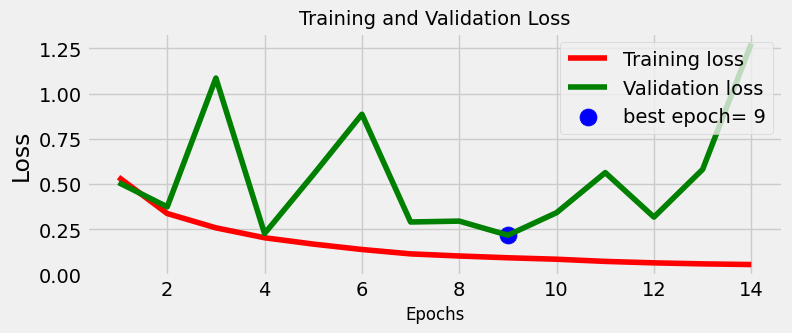

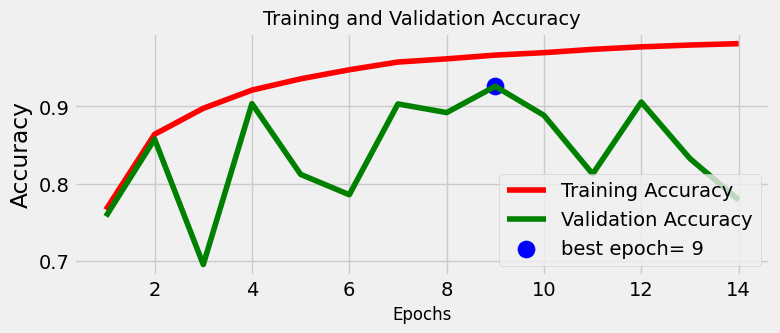

In [18]:
plot_loss_accuracy(history2)

In [19]:
tr_eval = model2.evaluate(train_gen) 
tr_loss = tr_eval[0]
tr_acc = tr_eval[1]

val_eval = model2.evaluate(valid_gen) 
val_loss = val_eval[0]
val_acc = val_eval[1]

test_eval = model2.evaluate(test_gen) 
test_loss = test_eval[0]
test_acc = test_eval[1]

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 75ms/step - accuracy: 0.9948 - loss: 0.0203
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.9254 - loss: 0.2297
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.9338 - loss: 0.2237


In [20]:
# define new model details
new_model_details ={'Model_Name':'model_2',
                        'tr_loss':tr_loss, 
                        'val_loss':val_loss, 
                        'test_loss':test_loss,
                        'tr_acc':tr_acc,
                        'val_acc':val_acc,
                        'test_acc':test_acc,
                        'no_of_conv_layers':2, 
                        'max_no_of_filters':max(f1,f2),
                        'no_of_dense_layers(hidden)':2, 
                        'no_of_neurons_at_first_hidden':d1, 
                        'padding':p,
                        'drop_out':drop,
                        'learning_rate':lr, 
                        'epochs':ep, 
                        }

new_model_details = pd.DataFrame([new_model_details])

# Append the new DataFrame to the existing one using pd.concat
models_details = pd.concat([models_details, new_model_details], ignore_index=True)


models_details

,Model_Name,tr_loss,val_loss,test_loss,tr_acc,val_acc,test_acc,no_of_conv_layers,max_no_of_filters,no_of_dense_layers(hidden),no_of_neurons_at_first_hidden,padding,drop_out,learning_rate,epochs
0,model_1,0.261125,0.345305,0.315903,0.89225,0.8492,0.8668,2,32,2,32,valid,0.4,0.0010,30
1,model_2,0.019798,0.217905,0.183728,0.99530,0.9260,0.9340,2,64,2,64,valid,0.2,0.0001,30


#### Model 3

In [36]:
lr=0.0001
drop = 0.4
f1 = 64
f2 = 32
d1 = 64
d2 = 32
p ='same'

model3 = Sequential([
    Conv2D(f1, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Conv2D(f2, kernel_size=(3,3),activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(d1,activation='relu'),
    Dropout(drop),
    
    Dense(d2,activation='relu' ),
    Dropout(drop),
    Dense(5, activation='softmax')
    
])

model3.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,846,501 (26.12 MB)

 Trainable params: 6,645,797 (25.35 MB)

 Non-trainable params: 200,704 (784.00 KB)

In [37]:
ep = 50
call_back3 = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5, verbose=0)
history3 = model3.fit(train_gen, epochs=ep, callbacks=call_back3, validation_data=valid_gen, verbose=1)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 81ms/step - accuracy: 0.5877 - loss: 1.1382 - val_accuracy: 0.7120 - val_loss: 0.6888
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 81ms/step - accuracy: 0.7205 - loss: 0.7502 - val_accuracy: 0.8036 - val_loss: 0.4682
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 101s 80ms/step - accuracy: 0.7685 - loss: 0.6257 - val_accuracy: 0.8636 - val_loss: 0.3441
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 98s 78ms/step - accuracy: 0.7890 - loss: 0.5690 - val_accuracy: 0.7508 - val_loss: 0.7625
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 105s 83ms/step - accuracy: 0.8120 - loss: 0.5093 - val_accuracy: 0.7340 - val_loss: 0.7732
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 101s 80ms/step - accuracy: 0.8334 - loss: 0.4632 - val_accuracy: 0.7988 - val_loss: 0.5183
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 82ms/step - accuracy: 0.8387 - loss: 0.4423 - val_accuracy: 0.7876 - val_loss: 0.5856
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 82ms/step - accuracy: 0

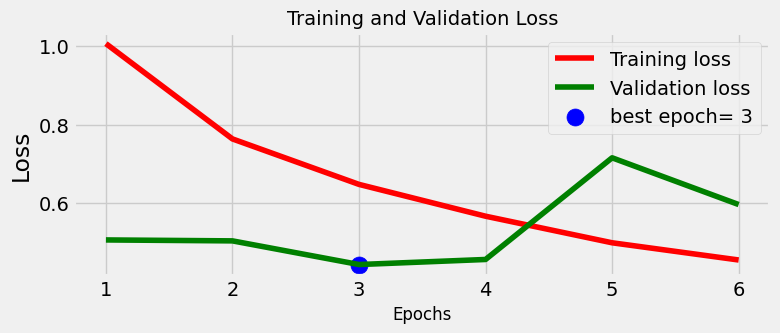

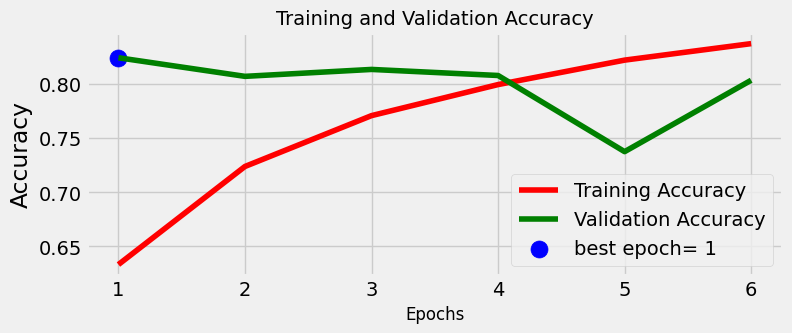

In [23]:
plot_loss_accuracy(history3)

In [24]:
tr_eval = model3.evaluate(train_gen) 
tr_loss = tr_eval[0]
tr_acc = tr_eval[1]

val_eval = model3.evaluate(valid_gen) 
val_loss = val_eval[0]
val_acc = val_eval[1]

test_eval = model3.evaluate(test_gen) 
test_loss = test_eval[0]
test_acc = test_eval[1]

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.8576 - loss: 0.4362
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.8365 - loss: 0.4975
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8364 - loss: 0.4865


In [25]:
# define new model details
new_model_details ={'Model_Name':'model_3',
                        'tr_loss':tr_loss, 
                        'val_loss':val_loss, 
                        'test_loss':test_loss,
                        'tr_acc':tr_acc,
                        'val_acc':val_acc,
                        'test_acc':test_acc,
                        'no_of_conv_layers':2, 
                        'max_no_of_filters':max(f1,f2),
                        'no_of_dense_layers(hidden)':2, 
                        'no_of_neurons_at_first_hidden':d1, 
                        'padding':p,
                        'drop_out':drop,
                        'learning_rate':lr, 
                        'epochs':ep, 
                        }

new_model_details = pd.DataFrame([new_model_details])

# Append the new DataFrame to the existing one using pd.concat
models_details = pd.concat([models_details, new_model_details], ignore_index=True)


models_details

,Model_Name,tr_loss,val_loss,test_loss,tr_acc,val_acc,test_acc,no_of_conv_layers,max_no_of_filters,no_of_dense_layers(hidden),no_of_neurons_at_first_hidden,padding,drop_out,learning_rate,epochs
0,model_1,0.261125,0.345305,0.315903,0.89225,0.8492,0.8668,2,32,2,32,valid,0.4,0.0010,30
1,model_2,0.019798,0.217905,0.183728,0.99530,0.9260,0.9340,2,64,2,64,valid,0.2,0.0001,30
2,model_3,0.444055,0.506139,0.465240,0.85505,0.8244,0.8492,2,64,2,64,same,0.4,0.0001,50


In [40]:
lr=0.00001
drop = 0.4
f1 = 64
f2 = 32
d1 = 64
d2 = 32
p ='same'

model4 = Sequential([
    Conv2D(f1, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Conv2D(f2, kernel_size=(3,3),activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(d1,activation='relu'),
    Dropout(drop),
    
    Dense(d2,activation='relu' ),
    Dropout(drop),
    Dense(5, activation='softmax')
    
])

model4.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100352)         │       401,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,846,501 (26.12 MB)

 Trainable params: 6,645,797 (25.35 MB)

 Non-trainable params: 200,704 (784.00 KB)

In [41]:
ep = 50
call_back4 = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5, verbose=0)
history4 = model4.fit(train_gen, epochs=ep, callbacks=call_back4, validation_data=valid_gen, verbose=1)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 102s 77ms/step - accuracy: 0.5086 - loss: 1.1437 - val_accuracy: 0.7192 - val_loss: 0.6150
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.6064 - loss: 0.9104 - val_accuracy: 0.7668 - val_loss: 0.5574
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 82ms/step - accuracy: 0.6276 - loss: 0.8598 - val_accuracy: 0.7864 - val_loss: 0.5213
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 84ms/step - accuracy: 0.6581 - loss: 0.7966 - val_accuracy: 0.7952 - val_loss: 0.4637
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - accuracy: 0.6762 - loss: 0.7628 - val_accuracy: 0.8188 - val_loss: 0.4391
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - accuracy: 0.6880 - loss: 0.7340 - val_accuracy: 0.8196 - val_loss: 0.4351
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 105s 84ms/step - accuracy: 0.7110 - loss: 0.6941 - val_accuracy: 0.7988 - val_loss: 0.4873
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 84ms/step - accuracy: 0

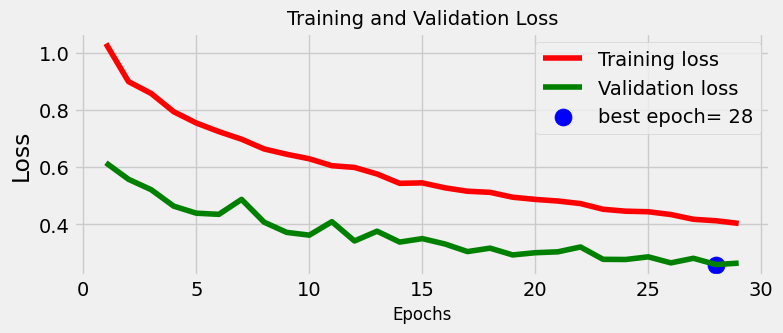

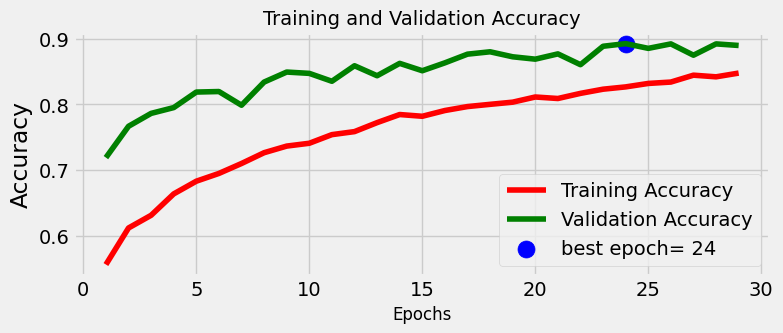

In [42]:
plot_loss_accuracy(history4)

In [43]:
tr_eval = model4.evaluate(train_gen) 
tr_loss = tr_eval[0]
tr_acc = tr_eval[1]

val_eval = model4.evaluate(valid_gen) 
val_loss = val_eval[0]
val_acc = val_eval[1]

test_eval = model4.evaluate(test_gen) 
test_loss = test_eval[0]
test_acc = test_eval[1]

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 88s 70ms/step - accuracy: 0.9594 - loss: 0.1531
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8801 - loss: 0.2982
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8945 - loss: 0.2688


In [44]:
# define new model details
new_model_details ={'Model_Name':'model_4',
                        'tr_loss':tr_loss, 
                        'val_loss':val_loss, 
                        'test_loss':test_loss,
                        'tr_acc':tr_acc,
                        'val_acc':val_acc,
                        'test_acc':test_acc,
                        'no_of_conv_layers':2, 
                        'max_no_of_filters':max(f1,f2),
                        'no_of_dense_layers(hidden)':2, 
                        'no_of_neurons_at_first_hidden':d1, 
                        'padding':p,
                        'drop_out':drop,
                        'learning_rate':lr, 
                        'epochs':ep, 
                        }

new_model_details = pd.DataFrame([new_model_details])

# Append the new DataFrame to the existing one using pd.concat
models_details = pd.concat([models_details, new_model_details], ignore_index=True)


models_details

,Model_Name,tr_loss,val_loss,test_loss,tr_acc,val_acc,test_acc,no_of_conv_layers,max_no_of_filters,no_of_dense_layers(hidden),no_of_neurons_at_first_hidden,padding,drop_out,learning_rate,epochs
0,model_1,0.261125,0.345305,0.315903,0.89225,0.8492,0.8668,2,32,2,32,valid,0.4,0.00100,30
1,model_2,0.019798,0.217905,0.183728,0.99530,0.9260,0.9340,2,64,2,64,valid,0.2,0.00010,30
2,model_3,0.444055,0.506139,0.465240,0.85505,0.8244,0.8492,2,64,2,64,same,0.4,0.00010,50
3,model_4,0.152503,0.277470,0.255336,0.95780,0.8924,0.9044,2,64,2,64,same,0.4,0.00001,50


## Best Model Archeticture

In [7]:
lr=0.00001
drop = 0.4
f1 = 64
f2 = 32
d1 = 128
d2 = 64
p ='valid'

model5 = Sequential([
    Conv2D(f1, kernel_size=(3,3), input_shape=(224,224,3), activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Conv2D(f2, kernel_size=(3,3),activation='relu', padding=p),
    MaxPooling2D((2,2)),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(d1,activation='relu'),
    Dropout(drop),
    
    Dense(d2,activation='relu' ),
    Dropout(drop),
    Dense(5, activation='softmax')
    
])

model5.compile(optimizer=Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 93312)          │       373,248 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,944,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,346,149 (47.10 MB)

 Trainable params: 12,159,525 (46.38 MB)

 Non-trainable params: 186,624 (729.00 KB)

In [8]:
ep = 50
call_back5 = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=5, verbose=0)
history5 = model5.fit(train_gen, epochs=ep, callbacks=call_back5, validation_data=valid_gen, verbose=1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/1250 ━━━━━━━━━━━━━━━━━━━━ 3:45:47 11s/step - accuracy: 0.3125 - loss: 1.9279

I0000 00:00:1721366823.924251     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721366823.948095     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 248s 190ms/step - accuracy: 0.5574 - loss: 1.0194 - val_accuracy: 0.7460 - val_loss: 0.5436
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.6647 - loss: 0.7665 - val_accuracy: 0.7724 - val_loss: 0.5090
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.6980 - loss: 0.6997 - val_accuracy: 0.8104 - val_loss: 0.4617
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.7241 - loss: 0.6543 - val_accuracy: 0.8308 - val_loss: 0.4186
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 108s 86ms/step - accuracy: 0.7545 - loss: 0.5896 - val_accuracy: 0.8400 - val_loss: 0.3902
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - accuracy: 0.7708 - loss: 0.5596 - val_accuracy: 0.8516 - val_loss: 0.3717
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 112s 89ms/step - accuracy: 0.7859 - loss: 0.5256 - val_accuracy: 0.8728 - val_loss: 0.3398
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 111s 88ms/step - accuracy: 0.8036 - l

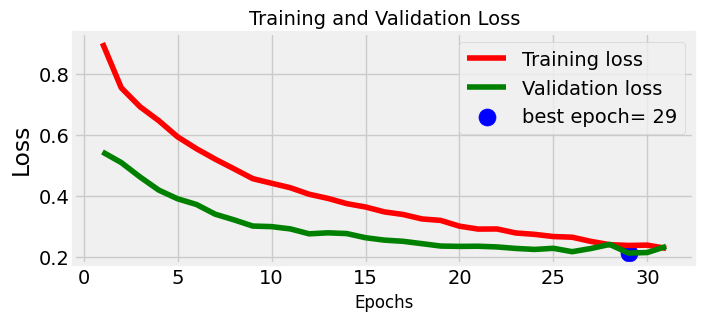

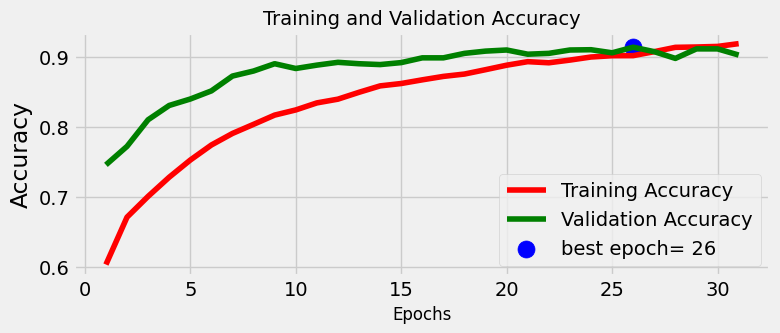

In [9]:
plot_loss_accuracy(history5)

## Model Testing and Evaluation

In [46]:
tr_eval = model5.evaluate(train_gen) 
tr_loss = tr_eval[0]
tr_acc = tr_eval[1]

val_eval = model5.evaluate(valid_gen) 
val_loss = val_eval[0]
val_acc = val_eval[1]

test_eval = model5.evaluate(test_gen) 
test_loss = test_eval[0]
test_acc = test_eval[1]

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 69ms/step - accuracy: 0.9832 - loss: 0.0739
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9062 - loss: 0.2289
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.9339 - loss: 0.1939


In [47]:
# define new model details
new_model_details ={'Model_Name':'model_5',
                        'tr_loss':tr_loss, 
                        'val_loss':val_loss, 
                        'test_loss':test_loss,
                        'tr_acc':tr_acc,
                        'val_acc':val_acc,
                        'test_acc':test_acc,
                        'no_of_conv_layers':2, 
                        'max_no_of_filters':max(f1,f2),
                        'no_of_dense_layers(hidden)':2, 
                        'no_of_neurons_at_first_hidden':d1, 
                        'padding':p,
                        'drop_out':drop,
                        'learning_rate':lr, 
                        'epochs':ep, 
                        }

new_model_details = pd.DataFrame([new_model_details])

# Append the new DataFrame to the existing one using pd.concat
models_details = pd.concat([models_details, new_model_details], ignore_index=True)


models_details

,Model_Name,tr_loss,val_loss,test_loss,tr_acc,val_acc,test_acc,no_of_conv_layers,max_no_of_filters,no_of_dense_layers(hidden),no_of_neurons_at_first_hidden,padding,drop_out,learning_rate,epochs
0,model_1,0.261125,0.345305,0.315903,0.89225,0.8492,0.8668,2,32,2,32,valid,0.4,0.00100,30
1,model_2,0.019798,0.217905,0.183728,0.99530,0.9260,0.9340,2,64,2,64,valid,0.2,0.00010,30
2,model_3,0.444055,0.506139,0.465240,0.85505,0.8244,0.8492,2,64,2,64,same,0.4,0.00010,50
3,model_4,0.152503,0.277470,0.255336,0.95780,0.8924,0.9044,2,64,2,64,same,0.4,0.00001,50
4,model_5,0.073319,0.217022,0.174034,0.98300,0.9140,0.9380,2,64,2,128,valid,0.4,0.00001,50


### The End!